# Исследование факторов коммерческого успеха видеоигр для интернет-магазина

_В этом исследовании необходимо проанализировать предоставленные данные за 2016 год для определения факторов, которые влияют на успех видеоигр на разных платформах. На основе проведенного анализа выявить потенциально популярный продукт, а так же скорректировать рекламный бюджет на 2017 год. Не менее важной целью будет проверка гипотез о равенстве средних пользовательских рейтингах разных платформ и жанров._

Основные задачи, которые необходимо решить в текущем исследовании:
- [изучиние данных и составление плана работ](#first_touch);
- [подготовка данных для анализа (предобработка, расчет дополнительных метрик)](#preprocessing);
- [исследовательский анализ данных](#analysis);
- [составление портрета пользователя для разных регионов](#user_portrait);
- [постановка и проверка гипотез](#hypotesis_and_ab_testing);
- [вывод](#conclusion).

## Изучение данных и составление плана работ <a id="first_touch"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import warnings

In [2]:
warnings.simplefilter("ignore")

In [3]:
games = pd.read_csv('/datasets/games.csv')

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1751,Test Drive: Off Road,PS,1997.0,Racing,0.65,0.44,0.00,0.08,NaN,NaN,NaN
9941,LEGO Batman 2: DC Super Heroes,WiiU,2013.0,Action,0.04,0.06,0.00,0.01,77.0,7.3,E10+
7028,Airblade,PS2,2001.0,Sports,0.11,0.09,0.00,0.03,70.0,5.8,T
11193,Fire Pro Wrestling Returns,PS2,2005.0,Sports,0.04,0.03,0.00,0.01,78.0,8.5,T
5049,Madden NFL 11,PSP,2010.0,Sports,0.35,0.00,0.00,0.03,NaN,tbd,E
6219,SimCity 2000,SAT,1994.0,Simulation,0.00,0.00,0.28,0.00,NaN,NaN,NaN
8244,Skate it,DS,2008.0,Sports,0.14,0.02,0.00,0.01,72.0,7.8,E
6706,Kung Fu Panda 2,X360,2011.0,Action,0.16,0.06,0.00,0.02,NaN,NaN,NaN
11204,Spider-Man: Edge of Time,Wii,2011.0,Action,0.06,0.02,0.00,0.01,62.0,5.2,T
13179,Sengoku Basara 4: Sumeragi,PS4,2015.0,Action,0.00,0.00,0.05,0.00,NaN,NaN,NaN


### Вывод

В результате первичного осмотра данных можно сделать вступительные выводы и очертить начальный план:
- индексы столбцов написаны с учетом верхнего регистра. Чтобы потом не путаться в названиях лучше привести их к единому нижнему регистру;
- дата выхода, где указывается только год, указана как данные типа float64. Чтобы иметь больше возможностей для манипуляций с датой ее лучше привести с соответствующему типу данных;
- данные о продажах записаны с точностью до десятков тысяч долларов. Не самая точная информация, особенно в такой валюте;
- данные по продажам есть для каждой игры во всех регионах, а вот оценка критиков только у половины игр. Очевидно что пропуск в этом столбце появляется когда оценка критиками не выставлена. Вероятно они ставят оценку играм только после того как те преодолели какой-то рубеж продаж. Либо PR кампания этих игр не опиралась на мнения критиков. Заменять на нулевые значения в этом столбце нет никакого смысла, они будут утягивать средние значения к низу, что нелучшим образом отразится на объективности. Я оставлю пропущеные значения в этом столбце без изменений;
- то же самое касается и пользовательских оценок, хотя их ощутимо больше чем оценок критиков. В этом столбце помимо пропусков встречается значение 'tbd'. Самое распространенное значение аббревиатуры tbd - To be determined и ознает она, что процесс оценки идет, но результат еще не достигнут. Простыми словами, скорее всего на сбор оценок по игре отводится определенное время и только после его окончания результаты подсчитываются. Вероятно в датафрейм занесены данные об играх, период оценки которых еще не закончился. Но после я изучил эти данные внимательнее и увидел что год релиза у игр мог быть и 2001 и 2003, так что вряд ли они не успели бы собрать оценки. Это значит что игры, скорее всего, не собрали критическую массу пользовательских оценок для расчета среднего значения. Например чтобы установить средний пользовательский рейтинг игры, необходимо получить 1000 оценок от игроков. И вот игра набрала любое количество оценок, но оно меньше 1000. Формально процесс оценки идет, нельзя указать что никаких оценок у игры нет, но количества оценок недостаточно чтобы достоверно определить средний рейтинг. Удалять эти значения как и нулевые нет необходимости, они приведут к искажению данных. Я оставлю их как есть;
- в столбце рейтинг так же есть пропуски значений. Сперва стоит отметить что в исследуемом датафрейме используется североамериканская ретинговая система, хотя игры продаются во всех регионах, тогда как в европе и Японии есть свои собственные системы оценки. Так же стоит отметить что все рейтинги для издателя носят рекомендательный характер и не могут накладывать юридические ограничения на продажи в том или ином регионе. Издатели присваивают ретинг своим играм на добровольной основе. Однако наличие рейтинга от соответвующей организации может потребовать площадка, на которой будет осуществляться продажа игры, будь то оффлайн магазин либо онлайн платформа. За отсутствием рейтинга она может отказать в размещении продукта в своем каталоге. Пропуски в столбце рейтинга указывают на тот факт, что издатели не поставили в   приоритет получить рейтинг. Причины у этого действия могут быть разные: например издатель точно знает что на тех площадках где будет продаваться игра необязательно наличие рейтинга, либо, продавая игру только в собственном магазине, издатель уверен что сможет привлечь достаточное количество покупателей, не прибегая к сторонним площадкам.

## Подготовка данных <a id="preprocessing"></a>

In [6]:
games.columns = games.columns.str.lower()

In [7]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
games['name'] = games['name'].fillna('unknown')

In [9]:
games.query('name == "unknown"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,unknown,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
games.dropna(subset=['genre'], inplace=True)
games = games.reset_index(drop=True)

In [11]:
games['year_of_release'] = games['year_of_release'].fillna(9999).astype('int')

In [12]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [13]:
games.duplicated().sum()

0

In [14]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

О действиях с отсутствующими значениями в столбцах рейтингов я подробно рассказал в выводе к предыдущему этапу. Помимо этих столбцов в датафрейме есть еще 3 столбца с пропусками. О подготовке данных я скажу следующее: 
- в столбцах 'name' и 'genre' есть по 2 пропуска. Внимательно изучив их я обнаружил что пропуски встречаются в одних и тех же строках. Эти строки не представляют особой ценности, потому что рассматриваемые игры были выпущены в далеком 1993 году, да еще и для платформы GEN (всего представителей этой платформы в рассматриваемом датафрейме - 27), имели сравнительно очень небольшие продажи, а так же не имели ни оценки критиков, ни оценки игроков, ни рейтинга. Эти строки не помогут ответить на поставленные в исследовании вопросы, поэтому, для чистоты данных, я их удаляю;
- в столбце 'year_of_release' 269 пропусков и записан он как тип float64. Строки с пропусками составляют 1.6% от всех данных. Вместо удаления я лучше заменю нули на нереальное значение, вероятно дальше при анализе эти строки смогу помочь мне своими другими данными. Дополнительно я привожу данные в этом столбце к челочисленному виду (int64), для более корректного вида записи года. (Сначала я подумал привести столбец 'year_of_release' к типу данных datetime64, после чего методом .dt.year оставить только год. Но потом выяснил что метод .dt.year возвращает значение года, при этом тип данных меняется на int64. И делать я этого не стал);
- дополнительная метрика (суммарные продажи) добавлена в датафрейм;
- полных дубликатов в данных не обнаружено.

Данные готовы для детального анализа.

## Исследовательский анализ данных <a id="analysis"></a>

_**Определение исследуемого периода**_

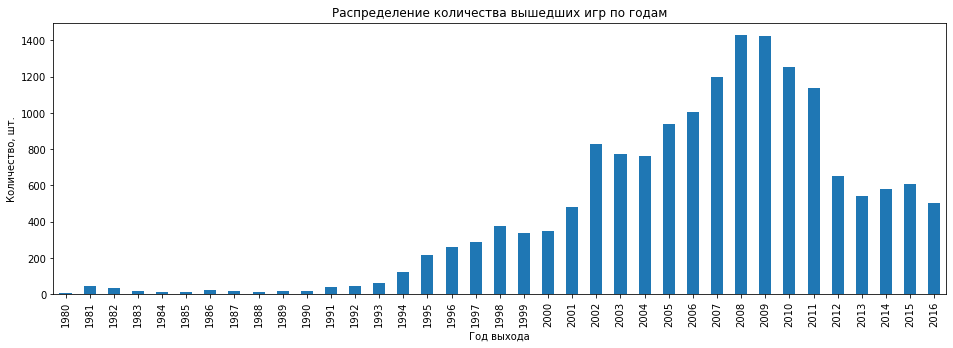

In [15]:
(games
 .query('year_of_release != 9999')
 .groupby('year_of_release')['name'].agg('count')
 .plot(kind='bar', figsize=(16,5), title='Распределение количества вышедших игр по годам')
)

plt.xlabel('Год выхода')
plt.ylabel('Количество, шт.')
plt.show()

По распределению количества выходивших игр в год видно что активный прирост начался в 1994 году. Именно в это время начинают появляться графические процессоры, способные обрабатывать 3D графику. Игры выходившие до 1994 года сложно назвать коммерчески ориентированными, поэтому далее я буду рассматривать период, начиная с этого года.

In [16]:
games_3d = games.query('1994 <= year_of_release != 9999').copy()

_**Распределение продаж самых популярных платформ**_

In [17]:
top_platforms = (games_3d
                 .groupby('platform')['total_sales'].agg('sum')
                 .sort_values(ascending=False)
                 .head(7)
)
top_platforms

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
PS4      314.14
Name: total_sales, dtype: float64

In [18]:
top_platforms_agg = (games_3d
                     .query('platform in @top_platforms.index')
                     .pivot_table(index='year_of_release', columns='platform', aggfunc={'total_sales':sum})
                    )

In [19]:
top_platforms_agg

total_sales                                                
platform                 DS      PS     PS2     PS3     PS4     Wii    X360
year_of_release                                                            
1994                    NaN    6.03     NaN     NaN     NaN     NaN     NaN
1995                    NaN   35.96     NaN     NaN     NaN     NaN     NaN
1996                    NaN   94.70     NaN     NaN     NaN     NaN     NaN
1997                    NaN  136.17     NaN     NaN     NaN     NaN     NaN
1998                    NaN  169.49     NaN     NaN     NaN     NaN     NaN
1999                    NaN  144.53     NaN     NaN     NaN     NaN     NaN
2000                    NaN   96.37   39.17     NaN     NaN     NaN     NaN
2001                    NaN   35.59  166.43     NaN     NaN     NaN     NaN
2002                    NaN    6.67  205.38     NaN     NaN     NaN     NaN
2003                    NaN    2.07  184.31     NaN     NaN     NaN     NaN
2004                  17.27     NaN  211.81     NaN     NaN     NaN     NaN
2005                 130.14     NaN  160.66     NaN     NaN     NaN    8.25
2006                 119.81     NaN  103.42   20.96     NaN  137.15   51.62
2007                 146.94     NaN   75.99   73.19     NaN  152.77   95.41
2008                 145.31     NaN   53.90  118.52     NaN  171.32  135.26
2009                 119.54     NaN   26.40  130.93     NaN  206.97  120.29
2010                  85.02     NaN    5.64  142.17     NaN  127.95  170.03
2011                  26.18     NaN    0.45  156.78     NaN   59.65  143.84
2012                  11.01     NaN     NaN  107.36     NaN   21.71   99.74
2013                   1.54     NaN     NaN  113.25   25.99    8.59   88.58
2014                    NaN     NaN     NaN   47.76  100.00    3.75   34.74
2015                    NaN     NaN     NaN   16.82  118.90    1.14   11.96
2016                    NaN     NaN     NaN    3.60   69.25    0.18    1.52

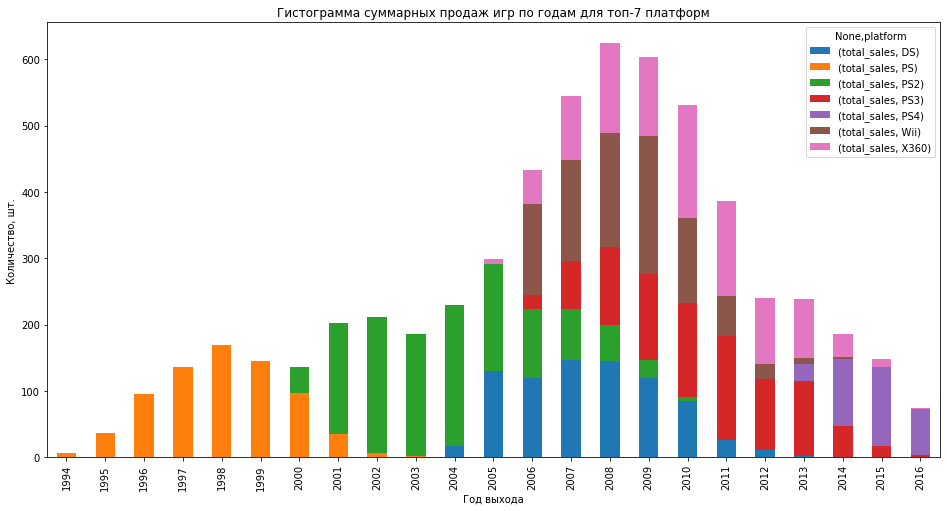

In [20]:
(top_platforms_agg
 .plot(figsize=(16,8), 
       kind='bar', 
       stacked=True,
       title='Гистограмма суммарных продаж игр по годам для топ-7 платформ')
)

plt.xlabel('Год выхода')
plt.ylabel('Количество, шт.')
plt.show()

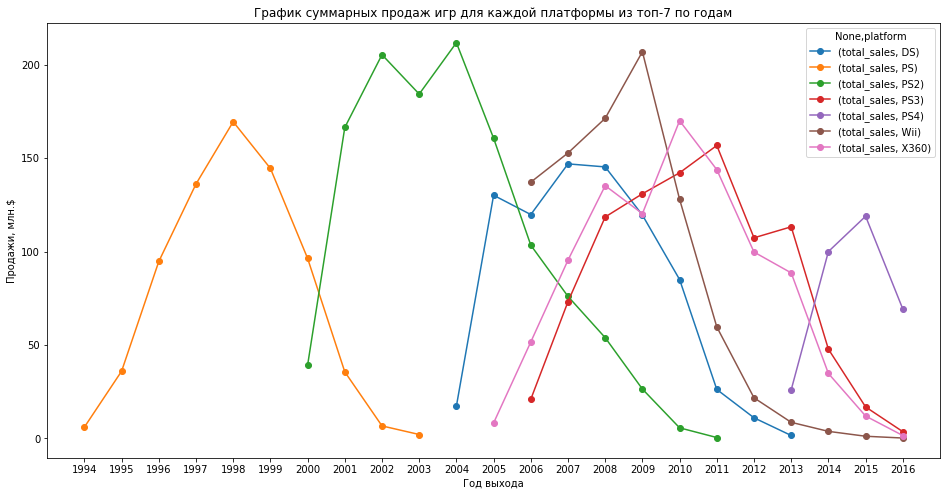

In [21]:
(top_platforms_agg
 .plot(figsize=(16,8), 
       style='-o', 
       xlim=(1993,2017),
       xticks=list(range(1994, 2017)),
      title='График суммарных продаж игр для каждой платформы из топ-7 по годам')
)

plt.xlabel('Год выхода')
plt.ylabel('Продажи, млн.$')
plt.show()

На последнем графике хорошо видно цикл жизни платформы. По нему можно сделать следующие выводы:
- средняя продолжительность жизни платформы - 10 лет;
- каждые 6-7 лет выходит новое поколение игровой платформы;
- через 3-4 года после выхода нового поколения, продажи игр ориентированное на предыдущее поколение платформы снижаются до нуля.

_**Актуальные данные**_

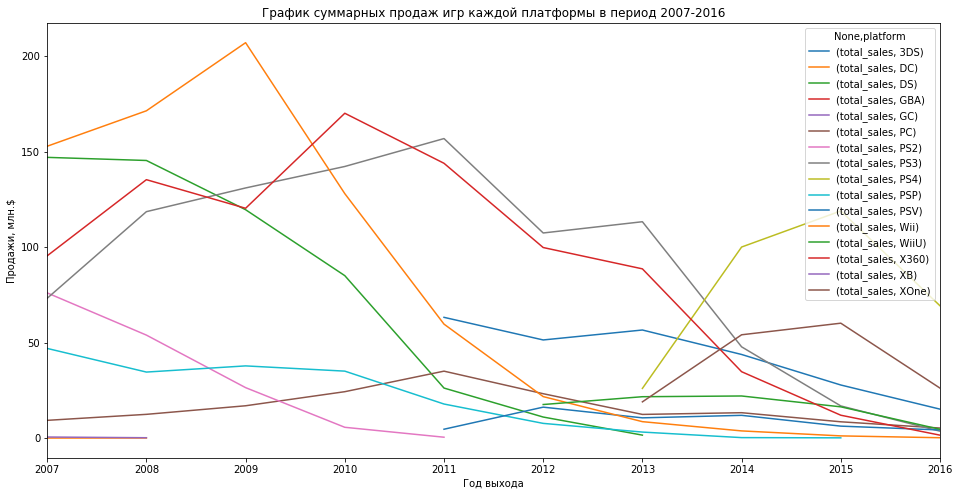

In [22]:
(games
.query('2007 <= year_of_release != 9999')
.pivot_table(index='year_of_release', columns='platform', aggfunc={'total_sales':sum})
.plot(figsize=(16,8), title='График суммарных продаж игр каждой платформы в период 2007-2016')
)

plt.xlabel('Год выхода')
plt.ylabel('Продажи, млн.$')
plt.show()

На предыдущем графике видно что подавляющее большинство платформ теряют свою атуальность. Продажи по всем платформам кроме 2, идут вниз. На мой взгляд будет логично предположить что интересующий нас период начинается с 2013 года, когда появляются 2 новых поколения основных игровых платформ - PS4 и XOne. Далее я буду рассматривать именно этот временной отрезок.

In [23]:
games_act = games.query('2013 <= year_of_release != 9999').copy()

In [24]:
(games_act
.pivot_table(index='year_of_release', columns='platform', aggfunc={'total_sales':sum})
)

total_sales                                                  \
platform                3DS    DS     PC     PS3     PS4   PSP    PSV   Wii   
year_of_release                                                               
2013                  56.57  1.54  12.38  113.25   25.99  3.14  10.59  8.59   
2014                  43.76   NaN  13.28   47.76  100.00  0.24  11.90  3.75   
2015                  27.78   NaN   8.52   16.82  118.90  0.12   6.25  1.14   
2016                  15.14   NaN   5.25    3.60   69.25   NaN   4.25  0.18   

                                      
platform          WiiU   X360   XOne  
year_of_release                       
2013             21.65  88.58  18.96  
2014             22.03  34.74  54.07  
2015             16.35  11.96  60.14  
2016              4.60   1.52  26.15

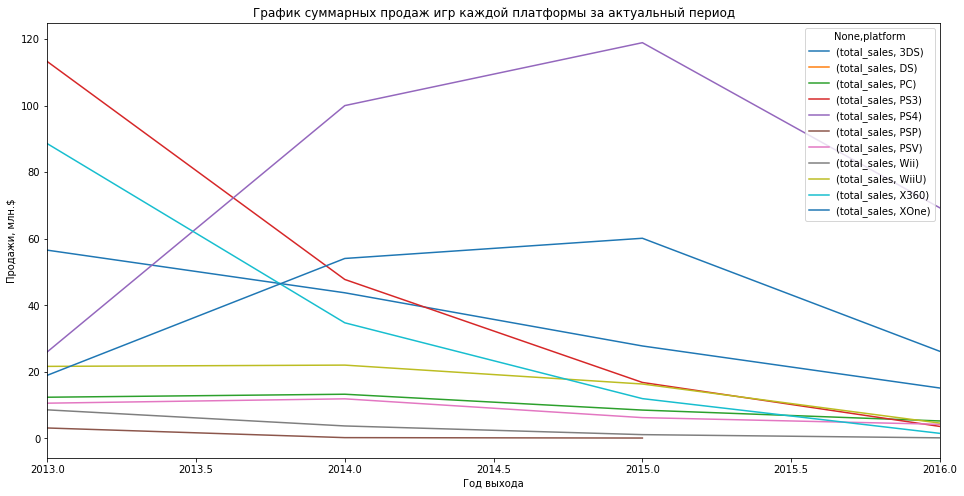

In [25]:
(games_act
.pivot_table(index='year_of_release', columns='platform', aggfunc={'total_sales':sum})
.plot(figsize=(16,8), title='График суммарных продаж игр каждой платформы за актуальный период')
)
plt.xlabel('Год выхода')
plt.ylabel('Продажи, млн.$')
plt.show()

5 из 11 актуальных, для рассматриваемего периода, игровых платформ: PSP, PSV, Wii, WiiU, PC - не выглядят потенциально прибыльными, доход каждой из них находится в диапазоне 0-20 млн.$ ежегодно. Платформа DS не генерирует дохода с продаж игр с 2013 года, она точно нам не подходит. Продажи игр для платформ PS3 и X360 стремительно падают с 2010-2011 года и к 2016 году уже приближаются к 0. Остается 3 платформы. 3DS - портативная игровая платформа от Nintendo радикально отличается от 2 других PS4 и XOne. Портативная платформа появилась в 2011 году и так же как и остальные теряет продажи последние годы. Так же поскольку игры для консолей и портативных платформ это продукты совершенно разного характера я остановлю свой выбор на 2 принципиально схожих платформах. Далее в анализе я буду рассматривать данные о платформах PS4 и XOne. Их продажи росли 2 года подряд после выхода на рынок в 2013. Но в 2016 году показали падение продаж. К сожалению на основе предоставленного датасета я не могу утвердительно ответить что стало причиной этому. Скорее всего причиной может быть тот факт что это лишь малая часть всех данных по продажам игр.

В любом случае я бы делал ставку на последнее поколение платформ, с их новейшими технологиями в области разработки игр.

In [26]:
profitable_platform = games_act.query('platform in ("PS4","XOne")')

_**Распределение глобальных продаж потенциально прибыльных платформ**_

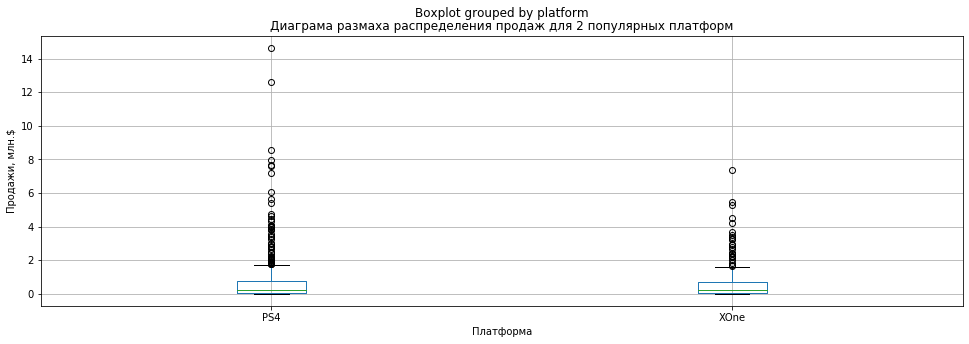

In [27]:
profitable_platform.boxplot('total_sales', by='platform', figsize=(16,5))

plt.xlabel('Платформа')
plt.ylabel('Продажи, млн.$')
plt.title('Диаграма размаха распределения продаж для 2 популярных платформ')
plt.show()

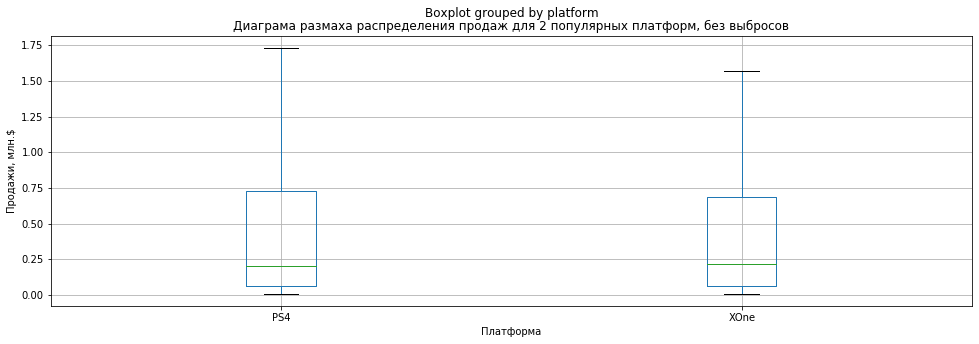

In [28]:
profitable_platform.boxplot('total_sales', by='platform', figsize=(16,5), showfliers=False)

plt.xlabel('Платформа')
plt.ylabel('Продажи, млн.$')
plt.title('Диаграма размаха распределения продаж для 2 популярных платформ, без выбросов')
plt.show()

In [29]:
profitable_platform.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.730,14.63
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.685,7.39


Согласно полученным данным можно сказать что в целом продажи для 2 выбранных платформ выглядят схожими. У 75% продаваемых игр на обоих платформах сумма мировых продаж находятся в близких, не очень больших значениях 680 - 730 тыс. долларов. А подавляющее количество игр имеют суммарные продажи в районе 1.5 - 1.75 млн. долларов. Это значит что для большинства издателей нет принципиальной разницы для какой платформы создавать свою игру, продажи будут схожими. Основное отличие приходится именно на те игры, которые подпадают под понятие выбросы.
У платформы PS4 гораздо чаще чем у XOne встречаются выбросы, а так же максимальное значение продаж у PS4 в 2 раза больше.
Именно этими факторами можно объяснить более высокое среднее значение у PS4.

Как итог можно сказать что для платформы PS4 чаще выходят коммерчески успешные игры. Все дело в эксклюзивных контрактах с Sony:)

_**Корелляция между отзывами и продажами**_

Самые популярная платформа в актуальном периоде - PS4. Ее я и буду рассматривать в рамках текущего вопроса.

In [30]:
popular_platform = games_act.query('platform == "PS4"').copy()

In [31]:
popular_platform['critic_score'].corr(popular_platform['total_sales'])

0.40656790206178095

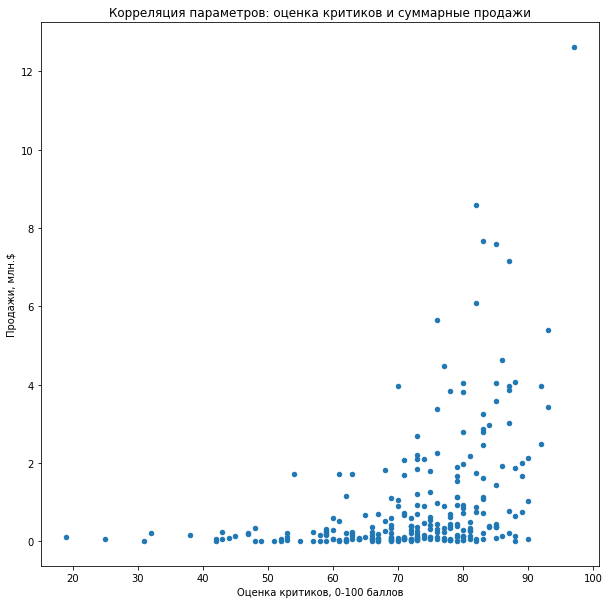

In [32]:
popular_platform.plot(kind='scatter', 
                      x='critic_score', 
                      y='total_sales',
                      figsize=(10,10),
                      title="Корреляция параметров: оценка критиков и суммарные продажи")

plt.xlabel('Оценка критиков, 0-100 баллов')
plt.ylabel('Продажи, млн.$')
plt.show()

In [33]:
popular_platform = popular_platform.loc[popular_platform['user_score'] != 'tbd']

In [34]:
popular_platform['user_score'] = popular_platform['user_score'].astype('float')

In [35]:
popular_platform['user_score'].corr(popular_platform['total_sales'])

-0.031957110204556424

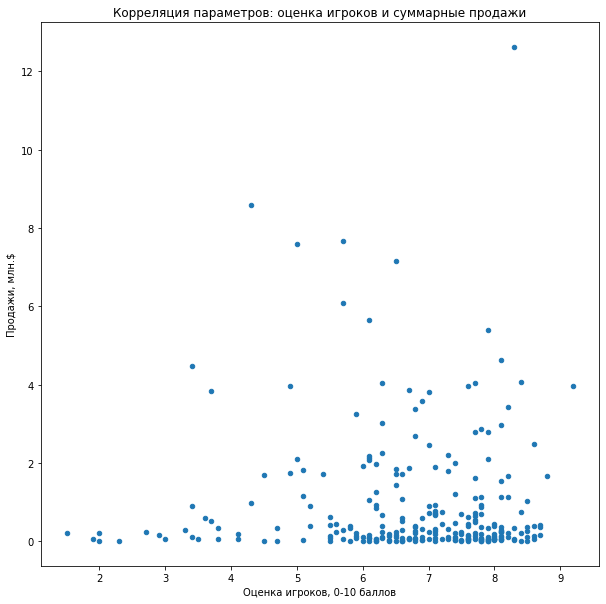

In [36]:
popular_platform.plot(kind='scatter', 
                      x='user_score', 
                      y='total_sales',
                      figsize=(10,10),
                      title="Корреляция параметров: оценка игроков и суммарные продажи")

plt.xlabel('Оценка игроков, 0-10 баллов')
plt.ylabel('Продажи, млн.$')
plt.show()

По результатам выявления зависимости между оценками критиков и пользователей и суммарными продажами можно сделать следующие выводы:
- коэффициент корреляция между оценками критиков и суммарными продажами 0.406. Это значение говорит нам что есть положительнй тренд на зависимость между этими параметрами, но он неярко выраженный. По графику видно что почти все игры находятся в диапазоне продаж до 5 млн. долларов, но при этом могут иметь совершенно любые оценки, основная масса лежит в диапазоне начиная с 40 и заканчивая 90 баллами. На игры с рейтингом от 70 баллов приходится самый большой разброс по суммарной выручке от продаж. Очевидную зависимость между этими параметрами не показал ни коэффициент Пирсона, ни диаграмма рассеяния;
- совершеннр иная картина в вопросе зависимости между оценкой игроков и суммарными продажами. В этом случае коэффициент Пирсона -0.032. Это, почти нулевое, значение говорит о том что взимосвязь исследумых параметров нелинейна и может быть выражена более комплексным методом. Для ее определения необходимо рассмотрение дополнительных факторов, вероятно с добавлением их весов. Основная масса оценок начинается с 5.5 баллов, а заканчивается 9 баллами. Начиная с 6 баллов пользовательского рейтинга, суммарные продажи имеют чуть большую волатильность.

In [37]:
popular_platform['user_score'].corr(popular_platform['critic_score'])

0.5576539782764632

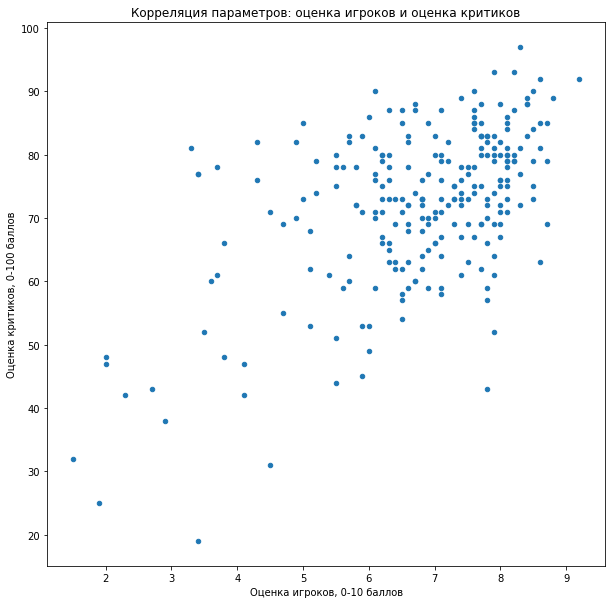

In [38]:
popular_platform.plot(kind='scatter', 
                      x='user_score', 
                      y='critic_score',
                      figsize=(10,10),
                      title="Корреляция параметров: оценка игроков и оценка критиков")

plt.xlabel('Оценка игроков, 0-10 баллов')
plt.ylabel('Оценка критиков, 0-100 баллов')
plt.show()

Интересно что зависимость между оценкой критиков и оценкой игроков имеет положительный устойчивый тренд, но она все равно далека от 100%.
По всей видимости мнение критиков и игроков часто не совпадают. Однако по графику кажется разрос выглядит симметрично относительно оси в 45 градусов.

_**Анализ прибыльности жанров**_

_Распределение игр по жанрам_

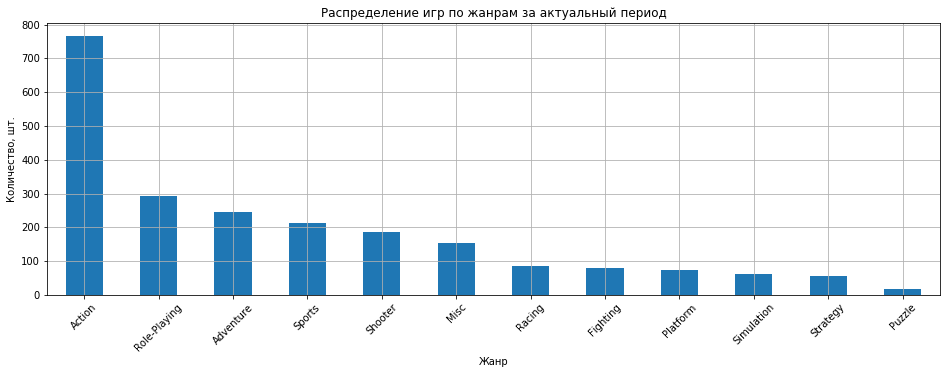

In [39]:
(games_act
 .groupby('genre')['total_sales'].agg('count')
 .sort_values(ascending=False)
 .plot(kind='bar', 
       grid=True, 
       rot=45, 
       figsize=(16,5), 
       title='Распределение игр по жанрам за актуальный период')
)

plt.xlabel('Жанр')
plt.ylabel('Количество, шт.')
plt.show()

_Распределение выручки по жанрам_

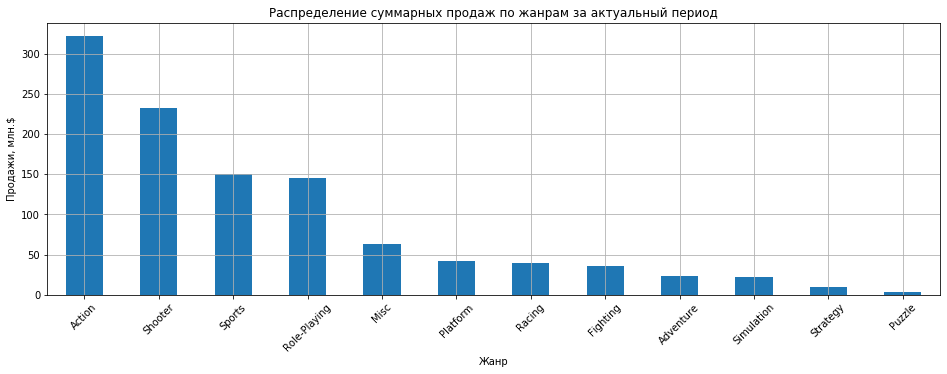

In [40]:
(games_act
 .groupby('genre')['total_sales'].agg('sum')
 .sort_values(ascending=False)
 .plot(kind='bar', 
       grid=True, 
       rot=45, 
       figsize=(16,5), 
       title='Распределение суммарных продаж по жанрам за актуальный период')
)

plt.xlabel('Жанр')
plt.ylabel('Продажи, млн.$')
plt.show()

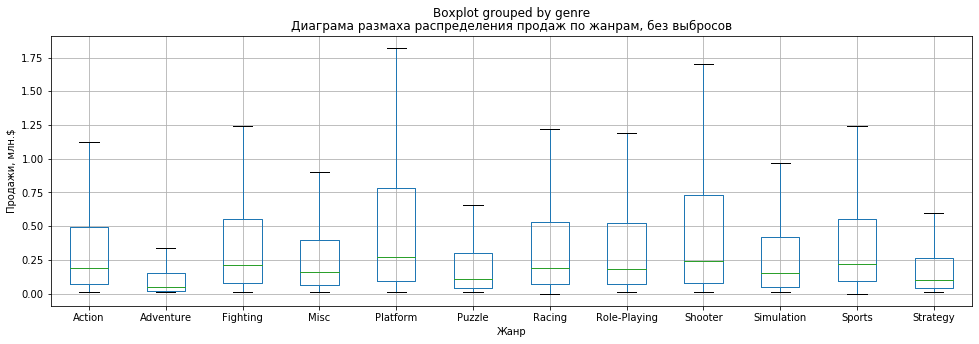

In [41]:
games.boxplot('total_sales', by='genre', figsize=(16,5), showfliers=False)

plt.xlabel('Жанр')
plt.ylabel('Продажи, млн.$')
plt.title('Диаграма размаха распределения продаж по жанрам, без выбросов')
plt.show()

Как видно по первым двум графикам самый многочисленный по числу игр жанр - Action, он же приносит больше всего дохода. Но хочется отдельно упомянуть очень важную деталь. Жанр Action это очень общее определение игрового жанра. Это собирательный образ из других поджанров. Иными словами современные игры не создаются в рамках одного жанра, вероятно это не слишком интересно игрокам, ведь набор действий в одножанровых играх сильно ограничен. Action это жанр игр в котором присутствуют элементы других более узких жанров, например: fighting, shooter, platform, racing и другие. Из-за чего игры получаеются насыщенными на механики и возможности вовлечения в игровой процесс. Поэтому жанр Action присваивают многим непохожим друг на друга играм, и его стоит рассматривать как очень обобщенный жанр игр. Это все равно что сказать что купе и универсал это легковые машины. Формально все корректно, но фактически это принципиально разные автомобили. Поэтому я предположу что жанр Action самый многочисленный потому что это собирательное, общее описание разных игр. А показатели продаж - усредненные по входящим в него поджанрам.

Интересная особенность что по количеству игр жанр Shooting на 5 месте, а по доходам на 2. Шутеров выпускается не так много, зато приносят они гораздо больше чем другие жанры. По распределению дохода видно что оно сильно скошено вправо и имеет 2 по величине медиану, больше только у платформеров. Оба этих замечания наталкивают на мысль что шутеры сложнее и затратнее в производстве, а так же имеют более разнообразные варианты монетизации помимо прямых продаж.

Диаметральная ситуация с жанром Adventure. Выпускается их даже больше чем шутеров, а приносят они несопоставимо меньше денег. Хуже дела только у пазлов, хотя это очень нишевый продукт. Вероятно приключения в чистом виде уже не так интересны игрокам, либо их производство бытро и не столь затратно как в шутерах. Скорее всего элемент приключения добавляют к шутерам или платформерам, а потом эти игры получают обощенный жанр Action.

## Портрет пользователя <a id="user_portrait"></a>

В конце этого раздела я сделал сводные таблицы по каждому рассматриваемому вопросу, для большей наглядности и информативности.

In [42]:
games_act['rating'] = games_act['rating'].fillna('unknown')

_**North America**_

_Tоп-5 платформ_

In [43]:
platform_na = (games_act
               .groupby('platform')['na_sales'].sum()
               .sort_values(ascending=False)
               .head(5)
               .to_frame()
               .reset_index()
              )

In [44]:
platform_na['%_of_market'] = platform_na['na_sales'] / games_act['na_sales'].sum()

In [45]:
na_other_sum = games_act.groupby('platform')['na_sales'].sum().sort_values(ascending=False).tail(6).sum()

In [46]:
na_other_share = na_other_sum / games_act['na_sales'].sum()

In [47]:
platform_na.loc[5] = ['other', na_other_sum, na_other_share]

In [48]:
platform_na.set_index('platform', inplace=True)

In [49]:
platform_na

,na_sales,%_of_market
platform,,
PS4,108.74,0.248429
XOne,93.12,0.212744
X360,81.66,0.186562
PS3,63.50,0.145073
3DS,38.20,0.087272
other,52.49,0.119920


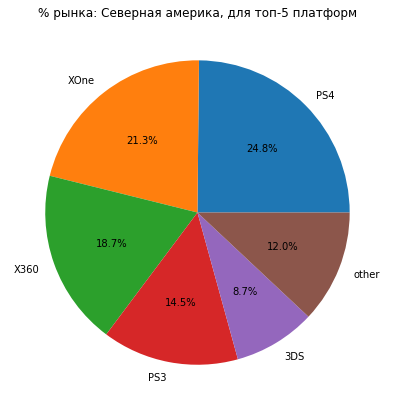

In [50]:
fig, ax = plt.subplots(figsize=(7,7))

ax.pie(platform_na['%_of_market'], labels=platform_na.index, autopct='%1.1f%%')

ax.set_title('% рынка: Северная америка, для топ-5 платформ')
plt.show()

_Топ-5 жанров_

In [51]:
genres_na = (games_act
             .query('na_sales != 0')
             .groupby('genre')['na_sales'].count()
             .sort_values(ascending=False)
             .head(5)
             .to_frame()
            )
genres_na

,na_sales
genre,
Action,442
Shooter,171
Role-Playing,158
Sports,143
Misc,84


_Распределение по рейтингу_

In [52]:
rating_na = (games_act
             .query('na_sales != 0')
             .pivot_table(index='rating', values='na_sales', aggfunc=('count', 'sum'))
            )
rating_na['share'] = rating_na['count'] / games_act.loc[games_act['na_sales'] != 0]['na_sales'].count()
rating_na

,count,sum,share
rating,,,
E,217,79.05,0.165775
E10+,220,54.24,0.168067
M,334,165.21,0.255157
T,240,49.79,0.183346
unknown,298,89.42,0.227655


_**Japan**_

_Топ-5 платформ_

In [53]:
platform_jp = (games_act
               .groupby('platform')['jp_sales'].sum()
               .sort_values(ascending=False)
               .head(5)
               .to_frame()
               .reset_index()
              )

In [54]:
platform_jp['%_of_market'] = platform_jp['jp_sales'] / games_act['jp_sales'].sum()

In [55]:
jp_other_sum = games_act.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).tail(6).sum()

In [56]:
jp_other_share = jp_other_sum / games_act['jp_sales'].sum()

In [57]:
platform_jp.loc[5] = ['other', jp_other_sum, jp_other_share]

In [58]:
platform_jp.set_index('platform', inplace=True)

In [59]:
platform_jp

,jp_sales,%_of_market
platform,,
3DS,67.81,0.481674
PS3,23.35,0.165862
PSV,18.59,0.132050
PS4,15.96,0.113368
WiiU,10.88,0.077284
other,4.19,0.029763


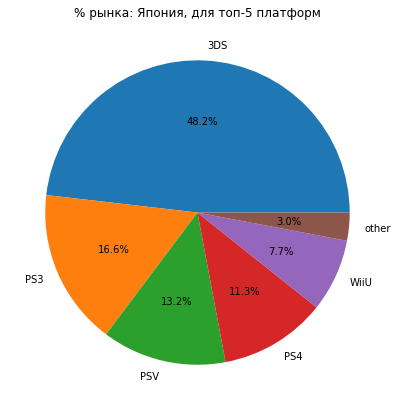

In [60]:
fig, ax = plt.subplots(figsize=(7,7))

ax.pie(platform_jp['%_of_market'], labels=platform_jp.index, autopct='%1.1f%%')

ax.set_title('% рынка: Япония, для топ-5 платформ')
plt.show()

_Топ-5 жанров_

In [61]:
genres_jp = (games_act
             .query('jp_sales != 0')
             .groupby('genre')['jp_sales'].count().sort_values(ascending=False).head(5).to_frame()
            )
genres_jp

,jp_sales
genre,
Action,400
Role-Playing,236
Adventure,165
Misc,90
Shooter,69


_Распределение по рейтингу_

In [62]:
rating_jp = (games_act
             .query('jp_sales != 0')
             .pivot_table(index='rating', values='jp_sales', aggfunc=('count', 'sum'))
            )
rating_jp['share'] = rating_jp['count'] / games_act.loc[games_act['jp_sales'] != 0]['jp_sales'].count()
rating_jp

,count,sum,share
rating,,,
E,77,15.14,0.064869
E10+,58,5.89,0.048863
M,159,14.11,0.133951
T,181,20.59,0.152485
unknown,712,85.05,0.599832


_**Europe**_

_Топ-5 платформ_

In [63]:
platform_eu = (games_act
               .groupby('platform')['eu_sales'].sum()
               .sort_values(ascending=False)
               .head(5)
               .to_frame()
               .reset_index()
              )

In [64]:
platform_eu['%_of_market'] = platform_eu['eu_sales'] / games_act['eu_sales'].sum()

In [65]:
eu_other_sum = games_act.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).tail(6).sum()

In [66]:
eu_other_share = eu_other_sum / games_act['eu_sales'].sum()

In [67]:
platform_eu.loc[5] = ['other',eu_other_sum, eu_other_share]

In [68]:
platform_eu.set_index('platform', inplace=True)

In [69]:
platform_eu

,eu_sales,%_of_market
platform,,
PS4,141.09,0.359712
PS3,67.81,0.172883
XOne,51.59,0.131530
X360,42.52,0.108406
3DS,30.96,0.078933
other,58.26,0.148535


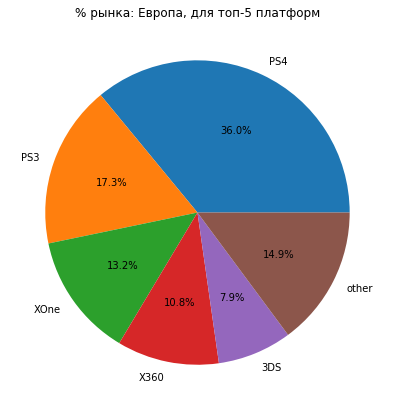

In [70]:
fig, ax = plt.subplots(figsize=(7,7))

ax.pie(platform_eu['%_of_market'], labels=platform_eu.index, autopct='%1.1f%%')

ax.set_title('% рынка: Европа, для топ-5 платформ')
plt.show()

_Топ-5 жанров_

In [71]:
genres_eu = (games_act
             .query('eu_sales != 0')
             .groupby('genre')['eu_sales'].count().sort_values(ascending=False).head(5).to_frame()
            )
genres_eu

,eu_sales
genre,
Action,494
Shooter,171
Sports,169
Role-Playing,155
Misc,80


_Распределение по рейтингу_

In [72]:
rating_eu = (games_act
             .query('eu_sales != 0')
             .pivot_table(index='rating', values='eu_sales', aggfunc=('count', 'sum'))
            )
rating_eu['share'] = rating_eu['count'] / games_act.loc[games_act['eu_sales'] != 0]['eu_sales'].count()
rating_eu

,count,sum,share
rating,,,
E,265,83.36,0.186357
E10+,231,42.69,0.162447
M,337,145.32,0.236990
T,253,41.95,0.177918
unknown,336,78.91,0.236287


### Сводные данные по разделу "Портрет пользователя"

In [73]:
platform_na.reset_index(inplace=True)
platform_na.columns = ['na_platform', 'na_sum', 'na_%_of_market']
platform_na['top'] = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5', 'other']
platform_jp.reset_index(inplace=True)
platform_jp.columns = ['jp_platform', 'jp_sum', 'jp_%_of_market']
platform_jp['top'] = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5', 'other']
platform_eu.reset_index(inplace=True)
platform_eu.columns = ['eu_platform', 'eu_sum', 'eu_%_of_market']
platform_eu['top'] = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5', 'other']

In [74]:
platform_report = platform_na.merge(platform_jp, on='top').merge(platform_eu, on='top')
platform_report.set_index('top', inplace=True)

In [75]:
genres_na.reset_index(inplace=True)
genres_na.columns = ['na_genre', 'na_count']
genres_na['top'] = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5']
genres_jp.reset_index(inplace=True)
genres_jp.columns = ['jp_genre', 'jp_count']
genres_jp['top'] = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5']
genres_eu.reset_index(inplace=True)
genres_eu.columns = ['eu_genre', 'eu_count']
genres_eu['top'] = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5']

In [76]:
genres_report = genres_na.merge(genres_jp, on='top').merge(genres_eu, on='top')
genres_report.set_index('top', inplace=True)

In [77]:
rating_na.reset_index(inplace=True)
rating_na.columns = ['rating', 'na_count', 'na_sum', 'na_share']
rating_jp.reset_index(inplace=True)
rating_jp.columns = ['rating', 'jp_count', 'jp_sum', 'jp_share']
rating_eu.reset_index(inplace=True)
rating_eu.columns = ['rating', 'eu_count', 'eu_sum', 'eu_share']

In [78]:
rating_report = rating_na.merge(rating_jp).merge(rating_eu)

In [79]:
platform_report

,na_platform,na_sum,na_%_of_market,jp_platform,jp_sum,jp_%_of_market,eu_platform,eu_sum,eu_%_of_market
top,,,,,,,,,
top_1,PS4,108.74,0.248429,3DS,67.81,0.481674,PS4,141.09,0.359712
top_2,XOne,93.12,0.212744,PS3,23.35,0.165862,PS3,67.81,0.172883
top_3,X360,81.66,0.186562,PSV,18.59,0.132050,XOne,51.59,0.131530
top_4,PS3,63.50,0.145073,PS4,15.96,0.113368,X360,42.52,0.108406
top_5,3DS,38.20,0.087272,WiiU,10.88,0.077284,3DS,30.96,0.078933
other,other,52.49,0.119920,other,4.19,0.029763,other,58.26,0.148535


В таблице platform_report сведены все данные о 5 самых популярных платформах в каждом рассматриваемом регионе. Так же в таблице рассчитана сумма всех продаж для каждой платформы и доля рынка в каждом регионе. Проанализировав получившийся датафрейм можно сделать следующие выводы:
- рынки северной америки и европы концептуально похожи друг на друга. 4 из 5 самых популярных платформ это конкурирущие между собой продукты компаний Sony и Microsoft - консоли PlayStation и Xbox соответственно. В обоих регионах первые 4 места занимают два последих поколения этих консолей. Они принципиально схожи в использовании, необходимо подключение приставок к ТВ. И в северной америке и в европе 2 бренда с 2 поколениями консолей занимают около 80% всего рынка видеоигр. Последнее поколение приставки от Sony занимает лидирующее место в обоих регионах. В североамериканском регионе Xbox близок к тому чтобы потеснить приставку от Sony, тодга как в европе позиции PS гораздо сильнее. В абсолютных продажах рынок северной америки больше европейского на 14.5%;
- второй схожей чертой рынка является тот факт что 5 место и там и там занимается японская портативная игровая консоль. Она не очень популярна относительно классических приставок, подключаемых к ТВ, и занимает 7-9% на обоих рынках. Стоит отметить что это самая популярная из всех портативных консолей в 2 регионах;
- на обоих рынках представлены и другие консоли, классические и портативные. Они занимают 12% на североамериканском рынке и 15% на европейском;
- японский рынок стоит особняком, по структуре он радикально отличается от двух предыдущих. Во-первых на японском рынке топ-5 самых популярных игровых платформ представлены исключительно японскими производителями. Во-вторых 61.5% всего рынка здесь занимают портативные игровые консоли от Sony и Nintendo. Больше половины всех игр продается на портативные консоли, это совершенно иной паттерн игрового поведения. Еще 35.5% приходится на классические приставки: 2 поколения PlayStation и последняя модель WiiU. Всего 3% рынка занимают остальные платформы. Выходя на этот рынок следует понимать что игроки привыкли совсем к другим правилам чем в северной америке или европе. 

In [80]:
genres_report

,na_genre,na_count,jp_genre,jp_count,eu_genre,eu_count
top,,,,,,
top_1,Action,442,Action,400,Action,494
top_2,Shooter,171,Role-Playing,236,Shooter,171
top_3,Role-Playing,158,Adventure,165,Sports,169
top_4,Sports,143,Misc,90,Role-Playing,155
top_5,Misc,84,Shooter,69,Misc,80


В отношении характера игрового контента все 3 региона похожи друг на друга. Но есть все некоторые особенности:
- первое место на всех 3 рынках занимает жанр Action. Причем опережает он ближайшего конкурента везде очень существенно. Это можно объяснить обобщенным характером этого жанра;
- дальше ситуация в европе и америке похожа, в обоих регионах на 2 месте жанр Shooter. Европейцы и американцы любят пострелять, чего нельзя сказать о японцах, у них жанр Shooter на последнем из популярных. В целом 2-4 места в европе и америке выглядят схожими. Эти места представлены одними и теми же жанрами в сравнительно близком количестве игр;
- последнее место в обоих случаях так же схоже, его представляет жанр Misc, количество игр почти одинковое;
- японцы снова выделяются на общем фоне. В пятерку популярных у них входит жанр Adventure, непопулярный в европе и америке, и неприбыльный как показали предыдущие исследования. Стоит отметить что жанр ролевых игр сильно популярен в Японии. Портативные консоли, ролевые игры - японский вкус специфичен. 

In [81]:
rating_report

,rating,na_count,na_sum,na_share,jp_count,jp_sum,jp_share,eu_count,eu_sum,eu_share
0,E,217,79.05,0.165775,77,15.14,0.064869,265,83.36,0.186357
1,E10+,220,54.24,0.168067,58,5.89,0.048863,231,42.69,0.162447
2,M,334,165.21,0.255157,159,14.11,0.133951,337,145.32,0.236990
3,T,240,49.79,0.183346,181,20.59,0.152485,253,41.95,0.177918
4,unknown,298,89.42,0.227655,712,85.05,0.599832,336,78.91,0.236287


Сперва стоит отметить что рейтинговая система ESRB гораздо более актуальна для европейского и североамериканского рынков. Менее четверти от всех продаваемых в этих регионах играх не имеют соответствующего рейтинга. Однако в Японии, только 40% продаваемых игр был присвоен рейтинг этой системы.

- Около четверти всех рейтингованных игр в европе и северной америке доступны для взрослых подростков от 17 лет. Тут может быть 2 причины, либо в этих регионах больше спрос на более взрослый (грубый, откровенный) контент, либо законодательство менее жестко его рейтингует. Возможно это сибиоз 2 факторов, на который накладывется соответствующая культа в которой растут дети. По результатам этого исследования становится очевидно что в европе и северной америке спрос на жестокость (шутеры) и взрослый контент выше чем в Японии. 23-25% в западном регионе и 13% в восточном;
- контента для детей (Е и Е10+) в Японии производится гораздо меньше чем в европе и северной америке (по крайней мере получает рейтинг), вероятно японским детям не очень интересен игровой контент, либо его пытаются искуственно ограничивать, во что конечно очень слабо верится;
- больше всего контента в Японии производится для подростков, а именно игр с рейтингом Т.

**Делая общий вывод этого раздела и составляя портрет пользователя каждого из регионов можно сказать следующее:**
- типичные пользователи из европы и северной америки похожи друг на друга. Они играют на классических консолях, а это значит дома, в игры жанра Action или Shooter, нередко с самым взрослым рейтингом. В этих регионах более выражен спрос на жестокий, агрессивный контент;
- типичный пользователь из Японии играет в основном в портативную консоль, вероятно часто вне дома. Популярностью помимо жанра Action пользуется жанр Role-Playing. Спрос на взрослый контент гораздо меньше, вероятно и средний возраст игрока в Японии ниже.

## Постановка и проверка гипотез <a id="hypotesis_and_ab_testing"></a>

Для проверки гипотез я буду использовать t-критерий Стьюдента. В обоих случаях выборки являются независимыми, а их распределения близки к нормальному.

### Гипотеза №1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Нулевая гипотеза: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC (наблюдаемые различия случайны).

Альтернативная гипотеза: средний пользовательский рейтинг платформы Xbox One отличается от среднего пользовательского рейтинга платформы PC.

Задача теста - опровергнуть нулевую гипотезу

alpha = 0.05 (5%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

In [82]:
xone = games_act.query('platform == "XOne" and user_score != "tbd"').dropna(subset=['user_score']).copy()

In [83]:
pc = games_act.query('platform == "PC" and user_score != "tbd"').dropna(subset=['user_score']).copy()

In [84]:
xone['user_score'] = xone['user_score'].astype('float')

In [85]:
pc['user_score'] = pc['user_score'].astype('float')

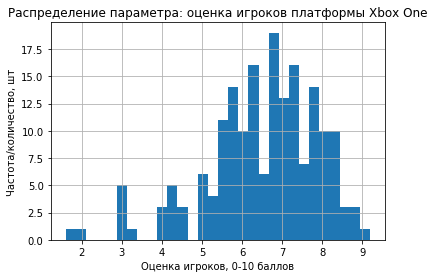

In [86]:
xone.hist('user_score', bins=30,)

plt.xlabel('Оценка игроков, 0-10 баллов')
plt.ylabel('Частота/количество, шт')
plt.title('Распределение параметра: оценка игроков платформы Xbox One')
plt.show()

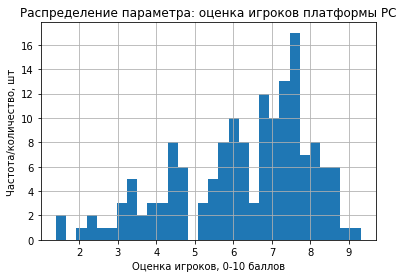

In [87]:
pc.hist('user_score', bins=30)

plt.xlabel('Оценка игроков, 0-10 баллов')
plt.ylabel('Частота/количество, шт')
plt.title('Распределение параметра: оценка игроков платформы PC')
plt.show()

In [88]:
xone['user_score'].mean()

6.521428571428572

In [89]:
pc['user_score'].mean()

6.2696774193548395

In [90]:
np.var(xone['user_score'])

1.8965188383045526

In [91]:
np.var(pc['user_score'])

3.016306347554631

In [92]:
results = st.ttest_ind(xone['user_score'], pc['user_score'], equal_var=False)

In [93]:
alpha = .05

In [94]:
print('p-value =',results.pvalue)

p-value = 0.14759594013430463


In [95]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


В результате применения t-критерия Стьюдента и проведения статистического теста я получил значение p-value равное 14.7%. Это означает что вероятность случайно опровергнуть нулевую гипотезу больше статистически значимой величины. Это значение нельзя проигнорировать. По итогу будет верным сказать что по результатам проведенного статистического теста, я не могу отвергнуть нулевую гипотезу. В рамках исследуемого датасета нельзя сказать что средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Результат подтверждается [сторонним тестом](https://www.evanmiller.org/ab-testing/t-test.html#!6.521429/1.377142/182;6.269677/1.736752/155@95)

### Гипотеза №2: средние пользовательские рейтинги жанров Action и Sports отличаются.

Нулевая гипотеза: средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports (наблюдаемые различия случайны).

Альтернативная гипотеза: средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports.

Задача теста - опровергнуть нулевую гипотезу

alpha = 0.05 (5%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

In [96]:
action = games_act.query('genre == "Action" and user_score != "tbd"').dropna(subset=['user_score']).copy()

In [97]:
sports = games_act.query('genre == "Sports" and user_score != "tbd"').dropna(subset=['user_score']).copy()

In [98]:
action['user_score'] = action['user_score'].astype('float')

In [99]:
sports['user_score'] = sports['user_score'].astype('float')

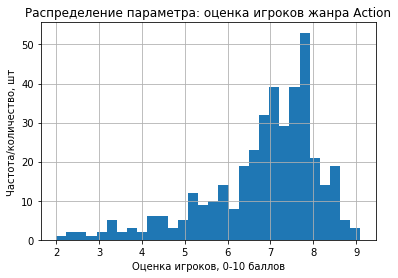

In [100]:
action.hist('user_score', bins=30)

plt.xlabel('Оценка игроков, 0-10 баллов')
plt.ylabel('Частота/количество, шт')
plt.title('Распределение параметра: оценка игроков жанра Action')
plt.show()

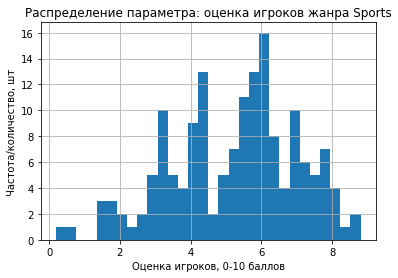

In [101]:
sports.hist('user_score', bins=30)

plt.xlabel('Оценка игроков, 0-10 баллов')
plt.ylabel('Частота/количество, шт')
plt.title('Распределение параметра: оценка игроков жанра Sports')
plt.show()

In [102]:
action['user_score'].mean()

6.837532133676092

In [103]:
sports['user_score'].mean()

5.238124999999999

In [104]:
np.var(action['user_score'])

1.7648124186332366

In [105]:
np.var(sports['user_score'])

3.160733984375

In [106]:
results_1 = st.ttest_ind(action['user_score'], sports['user_score'], equal_var=False)

In [107]:
alpha = .05

In [108]:
print('p-value =',results_1.pvalue)

p-value = 1.4460039700704315e-20


In [109]:
if (results_1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


В результате применения t-критерия Стьюдента и проведения статистического теста я получил значение p-value многократно меньше допустимого значение alpha. Вероятность случайно опровергнуть нулевую гипотезу меньше статистически значимой величины, это значит что будет совершенно корректно заявить что в результате проведения теста можно отвергнуть нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports отличаются.

Результат подтверждается [сторонним тестом](https://www.evanmiller.org/ab-testing/t-test.html#!6.837532/1.328462/389;5.238125/1.777845/160@95)

## Общий вывод <a id="conclusion"></a>

В рамках данной было проведено комплексное исследование рынка видеоигр. Мне удалось сформировать портрет типичного пользователя каждого регоина и детально определить его характерные черты. Дополнительным фактором стала проверка 2 гипотез. Комплексный исследовательский анализ, составление детального портрета пользоватля и проверка гипотез помогли сформировать ясное видение текущего положения дел на рынке видеоигр. Дополнительно эти выводы станут ключом к выбору потенциально коммерчески успешных игр в следующем году.

Можно с уверенностью сказать что для 3 регионов продаж необходимо выбирать 2 кардинально разные маркетинговые стратегии: 
- на рынках северной америки и европы более популярны игры в жанре Action и Shooter со взрослым рейтингом М, для классических консолей 2 ведущих производителей;
- на японском рынке стоит делать упор на продукт в жанре Action или Role-Playing с рейтингом T, для портативных консолей, направленный на подростков в возрасте от 13 лет.